In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels
from sklearn.model_selection import train_test_split


from xgboost import XGBRegressor
from sklearn import metrics

In [2]:
import urllib
params ='DRIVER={SQL Server};SERVER=CL-AMILAH\AMILA;DATABASE=GSH;UID=Amila;Trusted_Connection=yes;'            
params = urllib.parse.quote_plus(params)

from sqlalchemy import create_engine
db = create_engine('mssql+pyodbc:///?odbc_connect=%s' % params)

In [3]:
sql = '''
SELECT inv.[ID] ,inv.SiteUID, [Date] , [OutletUID] ,ot.Name AS outlet ,ot.ProvinceUID,pr.Description AS province ,ot.DistrictUID ,  di.Description AS district 
, ot.AreaUID , ar.Description AS Area , inv.[AgentUID] ,Concat(emp.FirstName ,' ' , emp.MiddleInitials , ' ', emp.LastName ) AS AgentName , inv.[DistributorUID] , d.Name AS distributor, [ItemUID] ,it.Description AS item, [UnitQty] 
, [UnitPrice] , [RetailUnitPrice] , [FreeQty] , [FreeCompanyQty] , [GrossValue]
,datename(YEAR, Date) AS Year
,datename(month, Date) AS MonthName
,MONTH(Date) AS Month
,datename(DAY, Date) AS Day
,DATEPART(DW,Date) AS WeekDay
,datename(WEEKDAY, Date) AS DateName
,DATEPART (hh,Date) as Hour

  FROM [GSH].[dbo].[vw_Invoice] inv
  LEFT JOIN [GSH].[dbo].[vw_InvoiceLine] invl
  ON inv.siteUID = invl.TxnInvoice_SiteUID AND inv.uid = invl.TxnInvoiceUID	
  LEFT JOIN [GSH].[dbo].[Item] it
  ON invl.ItemUID = it.UID
  LEFT JOIN [GSH].[dbo].[Outlet] ot
  ON inv.OutletUID = ot.UID
  LEFT JOIN [GSH].[dbo].[Area] pr
  ON ot.ProvinceUID = pr.UID
  LEFT JOIN [GSH].[dbo].[Area] di
  ON ot.DistrictUID = di.UID
  LEFT JOIN [GSH].[dbo].[Area] ar
  ON ot.AreaUID = ar.UID
  LEFT JOIN [GSH].[dbo].[Distributor] d
  ON inv.DistributorUID = d.UID
  LEFT JOIN [GSH].[dbo].[avLogin] avlg
  ON inv.AgentUID = avlg.BusinessUserUID
  LEFT JOIN [GSH].[dbo].[Employee] emp
  ON avlg.EmployeeUID = emp.UID
  WHERE inv.mpt_TypeEnum IN ( 21 , 44, 14, 1) AND inv.ExpiryDate IS NULL AND inv.SubmittedDate IS NOT NULL
  AND Date >= '2018-11-01' AND Date <= '2020-03-01' ;
'''

invoice_All = pd.read_sql_query(sql, db)

In [4]:
#disply all the columns
pd.set_option('display.max_columns', None)

In [5]:
invoice_All.head()

,ID,SiteUID,Date,OutletUID,outlet,ProvinceUID,province,DistrictUID,district,AreaUID,Area,AgentUID,AgentName,DistributorUID,distributor,ItemUID,item,UnitQty,UnitPrice,RetailUnitPrice,FreeQty,FreeCompanyQty,GrossValue,Year,MonthName,Month,Day,WeekDay,DateName,Hour
0,CSO011200326,94,2018-11-01 16:46:28.790,1768,Star Pharmacy,16.0,Southern Province,17.0,Galle,269.0,Devata,112,Surath Chamara,18,New Loyed Pharmacy,1,Cosvate G Cream 15gm,2.0,258.75,295.0,0.0,0.0,517.5,2018,November,11,1,5,Thursday,16
1,CSO011200326,94,2018-11-01 16:46:28.790,1768,Star Pharmacy,16.0,Southern Province,17.0,Galle,269.0,Devata,112,Surath Chamara,18,New Loyed Pharmacy,96,Fixon Powder-15gm,1.0,206.20,235.0,0.0,0.0,206.2,2018,November,11,1,5,Thursday,16
2,CSO011701378,54,2018-11-02 07:57:45.397,372,HEALTHY CARE PHARMACY,24.0,North Western Province,26.0,Puttalam,92.0,CHILAW,117,,2,The West Central Pharma (Pvt) Ltd.,42,Losatrust 25mg 100's,10.0,193.40,220.5,0.0,0.0,1934.0,2018,November,11,2,6,Friday,7
3,CSO011701378,54,2018-11-02 07:57:45.397,372,HEALTHY CARE PHARMACY,24.0,North Western Province,26.0,Puttalam,92.0,CHILAW,117,,2,The West Central Pharma (Pvt) Ltd.,42,Losatrust 25mg 100's,0.0,193.40,220.5,1.0,1.0,0.0,2018,November,11,2,6,Friday,7
4,CSO011801116,55,2018-11-02 08:00:16.220,3359,Dr.Chaminda Mendis,20.0,Western Province,23.0,Gampaha,95.0,Kandana,118,,2,The West Central Pharma (Pvt) Ltd.,87,Klatril Tab's 500mg 14's,50.0,657.65,749.7,0.0,0.0,32882.5,2018,November,11,2,6,Friday,8


In [8]:
# select product sales records 
#Belcid Suspension 240ml
Sec_invoices = invoice_All.loc[(invoice_All['ItemUID'] == 25)]

In [9]:
Sec_invoices

,ID,SiteUID,Date,OutletUID,outlet,ProvinceUID,province,DistrictUID,district,AreaUID,Area,AgentUID,AgentName,DistributorUID,distributor,ItemUID,item,UnitQty,UnitPrice,RetailUnitPrice,FreeQty,FreeCompanyQty,GrossValue,Year,MonthName,Month,Day,WeekDay,DateName,Hour
99,CSO009201195,110,2018-11-02 10:51:52.707,3557,Wimalasiri Pharmacy,16.0,Southern Province,17.0,Galle,265.0,Batapola,92,Chathura Gayashan,8,Kalyani Pharmacy,25,Belcid Suspension 240ml,10.0,216.7,247.0,0.0,0.0,2167.0,2018,November,11,2,6,Friday,10
100,CSO009201195,110,2018-11-02 10:51:52.707,3557,Wimalasiri Pharmacy,16.0,Southern Province,17.0,Galle,265.0,Batapola,92,Chathura Gayashan,8,Kalyani Pharmacy,25,Belcid Suspension 240ml,0.0,216.7,247.0,2.0,3.0,0.0,2018,November,11,2,6,Friday,10
398,CSO011600705,114,2018-11-02 15:07:56.900,3060,Centrel Pharmacy,20.0,Western Province,23.0,Gampaha,474.0,Kadawatha,116,,22,Lucky Impex,25,Belcid Suspension 240ml,10.0,216.7,247.0,0.0,0.0,2167.0,2018,November,11,2,6,Friday,15
399,CSO011600705,114,2018-11-02 15:07:56.900,3060,Centrel Pharmacy,20.0,Western Province,23.0,Gampaha,474.0,Kadawatha,116,,22,Lucky Impex,25,Belcid Suspension 240ml,0.0,216.7,247.0,3.0,3.0,0.0,2018,November,11,2,6,Friday,15
429,CSO009201190,110,2018-11-02 08:42:13.637,3284,Queens Pharmacy,16.0,Southern Province,17.0,Galle,265.0,Batapola,92,Chathura Gayashan,8,Kalyani Pharmacy,25,Belcid Suspension 240ml,10.0,216.7,247.0,0.0,0.0,2167.0,2018,November,11,2,6,Friday,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953652,CSO009405733,514,2020-02-17 14:47:30.970,710,Walikada Chemist,20.0,Western Province,21.0,Colombo,184.0,Rajagiriya,94,Amith Shalika,9,Multy Drugs (Pvt) Ltd,25,Belcid Suspension 240ml,0.0,264.0,308.0,9.0,9.0,0.0,2020,February,2,17,2,Monday,14
953654,CSO009405752,514,2020-02-18 22:30:12.843,918,New Tharul Pharmacy,20.0,Western Province,21.0,Colombo,140.0,Gonapola,94,Amith Shalika,9,Multy Drugs (Pvt) Ltd,25,Belcid Suspension 240ml,10.0,264.0,308.0,0.0,0.0,2640.0,2020,February,2,18,3,Tuesday,22
953655,CSO009405752,514,2020-02-18 22:30:12.843,918,New Tharul Pharmacy,20.0,Western Province,21.0,Colombo,140.0,Gonapola,94,Amith Shalika,9,Multy Drugs (Pvt) Ltd,25,Belcid Suspension 240ml,0.0,264.0,308.0,2.0,3.0,0.0,2020,February,2,18,3,Tuesday,22
953658,CSO009405755,514,2020-02-18 22:33:23.827,929,Lanka Pharmacy,20.0,Western Province,22.0,Kalutara,145.0,Horana,94,Amith Shalika,9,Multy Drugs (Pvt) Ltd,25,Belcid Suspension 240ml,50.0,264.0,308.0,0.0,0.0,13200.0,2020,February,2,18,3,Tuesday,22


In [10]:
Sec_invoices.head()

,ID,SiteUID,Date,OutletUID,outlet,ProvinceUID,province,DistrictUID,district,AreaUID,Area,AgentUID,AgentName,DistributorUID,distributor,ItemUID,item,UnitQty,UnitPrice,RetailUnitPrice,FreeQty,FreeCompanyQty,GrossValue,Year,MonthName,Month,Day,WeekDay,DateName,Hour
99,CSO009201195,110,2018-11-02 10:51:52.707,3557,Wimalasiri Pharmacy,16.0,Southern Province,17.0,Galle,265.0,Batapola,92,Chathura Gayashan,8,Kalyani Pharmacy,25,Belcid Suspension 240ml,10.0,216.7,247.0,0.0,0.0,2167.0,2018,November,11,2,6,Friday,10
100,CSO009201195,110,2018-11-02 10:51:52.707,3557,Wimalasiri Pharmacy,16.0,Southern Province,17.0,Galle,265.0,Batapola,92,Chathura Gayashan,8,Kalyani Pharmacy,25,Belcid Suspension 240ml,0.0,216.7,247.0,2.0,3.0,0.0,2018,November,11,2,6,Friday,10
398,CSO011600705,114,2018-11-02 15:07:56.900,3060,Centrel Pharmacy,20.0,Western Province,23.0,Gampaha,474.0,Kadawatha,116,,22,Lucky Impex,25,Belcid Suspension 240ml,10.0,216.7,247.0,0.0,0.0,2167.0,2018,November,11,2,6,Friday,15
399,CSO011600705,114,2018-11-02 15:07:56.900,3060,Centrel Pharmacy,20.0,Western Province,23.0,Gampaha,474.0,Kadawatha,116,,22,Lucky Impex,25,Belcid Suspension 240ml,0.0,216.7,247.0,3.0,3.0,0.0,2018,November,11,2,6,Friday,15
429,CSO009201190,110,2018-11-02 08:42:13.637,3284,Queens Pharmacy,16.0,Southern Province,17.0,Galle,265.0,Batapola,92,Chathura Gayashan,8,Kalyani Pharmacy,25,Belcid Suspension 240ml,10.0,216.7,247.0,0.0,0.0,2167.0,2018,November,11,2,6,Friday,8


In [11]:
#group data by invoice
Sec_invoices_Agg = Sec_invoices.groupby("ID").agg({'GrossValue':'sum' , 'MonthName' : 'max'}).reset_index()

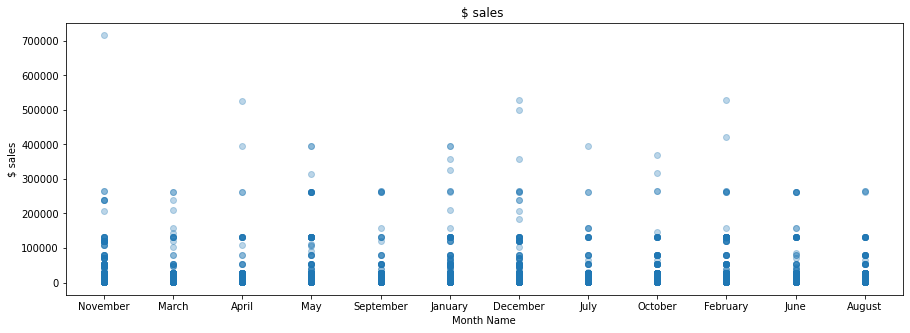

In [13]:
plt.scatter(Sec_invoices_Agg.MonthName , Sec_invoices_Agg.GrossValue , alpha=0.3,cmap='viridis')
plt.xlabel("Month Name")
plt.ylabel("$ sales")
plt.title("$ sales ")
plt.rcParams['figure.figsize'] = [15, 5]
plt.show()

In [14]:
# remove z score > 3 
Selc_Inv_Nor = Sec_invoices_Agg[(np.abs(stats.zscore(Sec_invoices_Agg["GrossValue"])) < 3)]

In [15]:
Selc_Inv_Nor.head()

,ID,GrossValue,MonthName
0,BO0092000094,2387.0,November
1,BO0092000098,11935.0,November
2,BO0092000099,2387.0,November
3,BO0092000100,7161.0,November
4,BO0092000101,2387.0,November


In [16]:
Sected_invoices_Nor = Sec_invoices[Sec_invoices['ID'].isin(Selc_Inv_Nor.ID)]

In [17]:
Sected_invoices_Nor.head()

,ID,SiteUID,Date,OutletUID,outlet,ProvinceUID,province,DistrictUID,district,AreaUID,Area,AgentUID,AgentName,DistributorUID,distributor,ItemUID,item,UnitQty,UnitPrice,RetailUnitPrice,FreeQty,FreeCompanyQty,GrossValue,Year,MonthName,Month,Day,WeekDay,DateName,Hour
99,CSO009201195,110,2018-11-02 10:51:52.707,3557,Wimalasiri Pharmacy,16.0,Southern Province,17.0,Galle,265.0,Batapola,92,Chathura Gayashan,8,Kalyani Pharmacy,25,Belcid Suspension 240ml,10.0,216.7,247.0,0.0,0.0,2167.0,2018,November,11,2,6,Friday,10
100,CSO009201195,110,2018-11-02 10:51:52.707,3557,Wimalasiri Pharmacy,16.0,Southern Province,17.0,Galle,265.0,Batapola,92,Chathura Gayashan,8,Kalyani Pharmacy,25,Belcid Suspension 240ml,0.0,216.7,247.0,2.0,3.0,0.0,2018,November,11,2,6,Friday,10
398,CSO011600705,114,2018-11-02 15:07:56.900,3060,Centrel Pharmacy,20.0,Western Province,23.0,Gampaha,474.0,Kadawatha,116,,22,Lucky Impex,25,Belcid Suspension 240ml,10.0,216.7,247.0,0.0,0.0,2167.0,2018,November,11,2,6,Friday,15
399,CSO011600705,114,2018-11-02 15:07:56.900,3060,Centrel Pharmacy,20.0,Western Province,23.0,Gampaha,474.0,Kadawatha,116,,22,Lucky Impex,25,Belcid Suspension 240ml,0.0,216.7,247.0,3.0,3.0,0.0,2018,November,11,2,6,Friday,15
429,CSO009201190,110,2018-11-02 08:42:13.637,3284,Queens Pharmacy,16.0,Southern Province,17.0,Galle,265.0,Batapola,92,Chathura Gayashan,8,Kalyani Pharmacy,25,Belcid Suspension 240ml,10.0,216.7,247.0,0.0,0.0,2167.0,2018,November,11,2,6,Friday,8


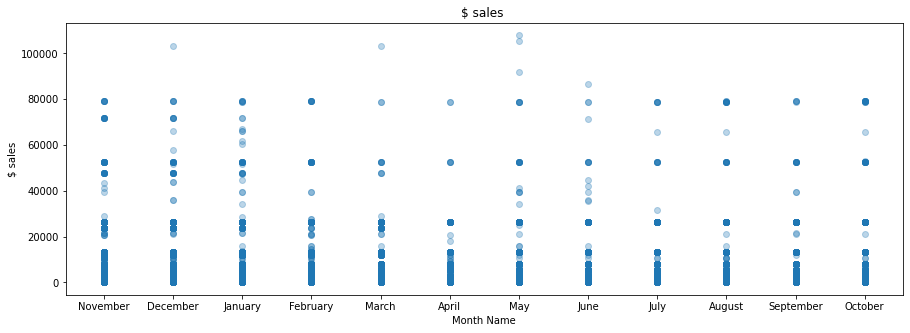

In [18]:
plt.scatter(Sected_invoices_Nor.MonthName , Sected_invoices_Nor.GrossValue , alpha=0.3,cmap='viridis')
plt.xlabel("Month Name")
plt.ylabel("$ sales")
plt.title("$ sales ")
plt.rcParams['figure.figsize'] = [15, 5]
plt.show()

In [19]:
#group data by invoice:
Sec_invoices_grp = Sec_invoices.groupby("ID").agg({'OutletUID' :'max', 'DistributorUID':'max','UnitQty':'sum', 'UnitPrice':'max'
                                                   ,'FreeQty':'sum', 'FreeCompanyQty':'sum' ,'Year': 'max' 
                                                   ,'ProvinceUID': 'max' ,'DistrictUID': 'max' , 'AreaUID':'max' 
                                                   ,'GrossValue':'sum' , 'Month' : 'max'}).reset_index()

In [20]:
Sec_invoices_grp.head()

,ID,OutletUID,DistributorUID,UnitQty,UnitPrice,FreeQty,FreeCompanyQty,Year,ProvinceUID,DistrictUID,AreaUID,GrossValue,Month
0,BO0092000094,1645,8,10.0,238.7,3.0,3.0,2018,20.0,22.0,259.0,2387.0,11
1,BO0092000098,1698,8,50.0,238.7,15.0,15.0,2018,16.0,17.0,260.0,11935.0,11
2,BO0092000099,1703,8,10.0,238.7,3.0,3.0,2018,16.0,17.0,260.0,2387.0,11
3,BO0092000100,1675,8,30.0,238.7,9.0,9.0,2018,16.0,17.0,263.0,7161.0,11
4,BO0092000101,3274,8,10.0,238.7,3.0,3.0,2018,16.0,17.0,277.0,2387.0,11


In [21]:
Sec_invoices_grp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10116 entries, 0 to 10115
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              10116 non-null  object 
 1   OutletUID       10116 non-null  int64  
 2   DistributorUID  10116 non-null  int64  
 3   UnitQty         10116 non-null  float64
 4   UnitPrice       10116 non-null  float64
 5   FreeQty         10116 non-null  float64
 6   FreeCompanyQty  10116 non-null  float64
 7   Year            10116 non-null  object 
 8   ProvinceUID     10115 non-null  float64
 9   DistrictUID     10115 non-null  float64
 10  AreaUID         10115 non-null  float64
 11  GrossValue      10116 non-null  float64
 12  Month           10116 non-null  int64  
dtypes: float64(8), int64(3), object(2)
memory usage: 1.0+ MB


In [22]:
Sec_invoices_grp['Year'] = Sec_invoices_grp['Year'].astype(str).astype(int)

In [23]:
Sec_invoices_grp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10116 entries, 0 to 10115
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              10116 non-null  object 
 1   OutletUID       10116 non-null  int64  
 2   DistributorUID  10116 non-null  int64  
 3   UnitQty         10116 non-null  float64
 4   UnitPrice       10116 non-null  float64
 5   FreeQty         10116 non-null  float64
 6   FreeCompanyQty  10116 non-null  float64
 7   Year            10116 non-null  int32  
 8   ProvinceUID     10115 non-null  float64
 9   DistrictUID     10115 non-null  float64
 10  AreaUID         10115 non-null  float64
 11  GrossValue      10116 non-null  float64
 12  Month           10116 non-null  int64  
dtypes: float64(8), int32(1), int64(3), object(1)
memory usage: 988.0+ KB


In [24]:
X = Sec_invoices_grp[["OutletUID","ProvinceUID","DistrictUID", "AreaUID" ,"DistributorUID","UnitPrice","Year","Month"]]
#X = Sec_invoices_grp[["OutletUID" ,"DistributorUID","UnitPrice","Year","Month"]]
y = Sec_invoices_grp[["GrossValue"]]

In [26]:
y.head()

,GrossValue
0,2387.0
1,11935.0
2,2387.0
3,7161.0
4,2387.0


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [28]:
print(X.shape, X_train.shape, X_test.shape)

(10116, 8) (8092, 8) (2024, 8)


XGBoost Regressor

In [29]:
regressor = XGBRegressor()

In [30]:
regressor.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [31]:
# prediction on training data
training_data_prediction = regressor.predict(X_train)

In [32]:
# R squared Value
r2_train = metrics.r2_score(y_train, training_data_prediction)

In [33]:
print('R Squared value = ', r2_train)

R Squared value =  0.8883063924861284


### Since R Squared is 0.88 the 88% of training data is considered to be predicted correctly. 

In [34]:
# prediction on test data
test_data_prediction = regressor.predict(X_test)

In [35]:
# R squared Value
r2_test = metrics.r2_score(y_test, test_data_prediction)

In [36]:
print('R Squared value = ', r2_test)

R Squared value =  0.5086136266644206


### Since R Squared is 0.50 the 50% of test data is considered to be predicted correctly. 

In [37]:
y_test

,GrossValue
6874,1056.0
3938,7920.0
2589,2632.0
8616,2632.0
4850,7920.0
...,...
4367,2632.0
5677,23870.0
6806,2640.0
7234,2387.0


In [38]:
test_data_prediction

array([ 1351.6953,  5424.8203, 57223.37  , ...,  2308.142 ,  4406.58  ,
        7565.2124], dtype=float32)

In [39]:
# get data to DF
Final_Result = X_test
Final_Result["GrossValue"] = y_test
Prd_Results = pd.DataFrame(data = test_data_prediction, columns = ['GrossValuePrd'], index = X_test.index.copy())
Final_Result = pd.merge(Final_Result, Prd_Results, how = 'left', left_index = True, right_index = True)

In [40]:
Final_Result

,OutletUID,ProvinceUID,DistrictUID,AreaUID,DistributorUID,UnitPrice,Year,Month,GrossValue,GrossValuePrd
6874,4243,16.0,18.0,410.0,14,264.0,2020,1,1056.0,1351.695312
3938,3453,16.0,17.0,289.0,8,264.0,2020,1,7920.0,5424.820312
2589,3588,6.0,9.0,240.0,7,263.2,2019,3,2632.0,57223.371094
8616,2258,20.0,22.0,52.0,24,263.2,2019,8,2632.0,3242.624756
4850,706,20.0,21.0,184.0,9,264.0,2019,12,7920.0,8437.918945
...,...,...,...,...,...,...,...,...,...,...
4367,662,20.0,21.0,160.0,9,263.2,2019,4,2632.0,4900.075684
5677,4615,30.0,32.0,368.0,13,238.7,2018,11,23870.0,10869.597656
6806,5165,16.0,18.0,396.0,14,264.0,2019,12,2640.0,2308.142090
7234,2981,20.0,23.0,484.0,22,238.7,2019,1,2387.0,4406.580078


In [41]:
Final_Result = Final_Result.sort_index()
Final_Result = Final_Result.reset_index()

In [42]:
Final_Result.head()

,index,OutletUID,ProvinceUID,DistrictUID,AreaUID,DistributorUID,UnitPrice,Year,Month,GrossValue,GrossValuePrd
0,3,1675,16.0,17.0,263.0,8,238.7,2018,11,7161.0,5605.153809
1,10,2276,20.0,22.0,52.0,24,238.7,2019,3,2387.0,2492.021973
2,20,2143,20.0,21.0,340.0,24,238.7,2019,4,11935.0,5014.014160
3,30,2250,20.0,21.0,60.0,24,263.2,2019,5,2632.0,13879.785156
4,32,2143,20.0,21.0,340.0,24,263.2,2019,5,7896.0,8865.046875


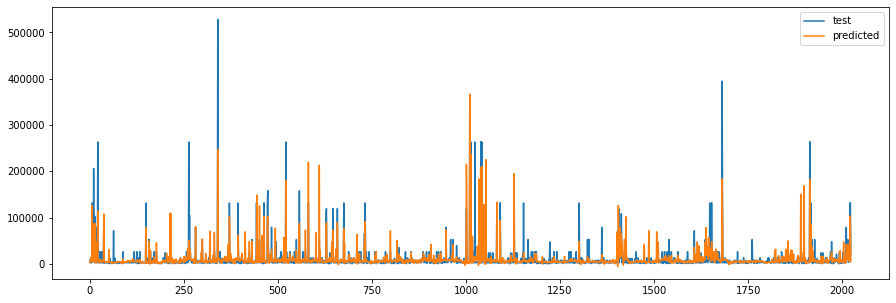

In [43]:
plt.plot(Final_Result.GrossValue)
plt.plot(Final_Result.GrossValuePrd)
plt.legend(['test', 'predicted'])

In [51]:
# remove z score > 3
Final_Result_No_Out = Final_Result[(np.abs(stats.zscore(Final_Result["GrossValue"])) < 3)]

In [52]:
Final_Result_No_Out

,index,OutletUID,ProvinceUID,DistrictUID,AreaUID,DistributorUID,UnitPrice,Year,Month,GrossValue,GrossValuePrd
0,3,1675,16.0,17.0,263.0,8,238.7,2018,11,7161.0,5605.153809
1,10,2276,20.0,22.0,52.0,24,238.7,2019,3,2387.0,2492.021973
2,20,2143,20.0,21.0,340.0,24,238.7,2019,4,11935.0,5014.014160
3,30,2250,20.0,21.0,60.0,24,263.2,2019,5,2632.0,13879.785156
4,32,2143,20.0,21.0,340.0,24,263.2,2019,5,7896.0,8865.046875
...,...,...,...,...,...,...,...,...,...,...,...
2017,10085,2849,10.0,11.0,415.0,25,216.7,2019,10,3467.2,15175.538086
2018,10095,2859,10.0,15.0,454.0,25,264.0,2019,12,26400.0,5935.994629
2019,10096,2893,10.0,12.0,423.0,25,264.0,2019,12,26400.0,14339.264648
2020,10100,2773,10.0,11.0,425.0,25,264.0,2020,1,7920.0,14095.825195


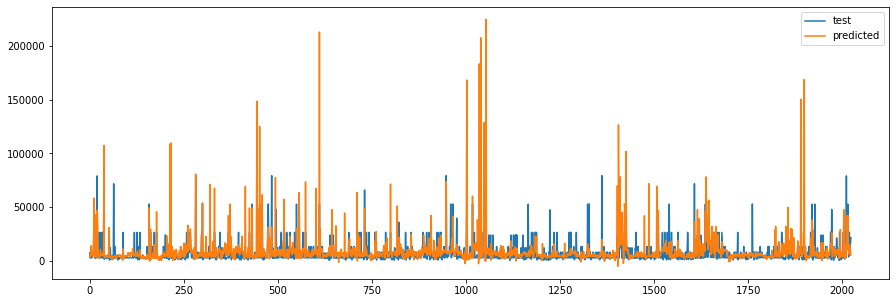

In [53]:
plt.plot(Final_Result_No_Out.GrossValue)
plt.plot(Final_Result_No_Out.GrossValuePrd)
plt.legend(['test', 'predicted'])

In [58]:
# GrossValue and GrossValuePrd less than 100,000
Final_Result_No_Out = Final_Result.loc[(Final_Result['GrossValue'] < 100000) & (Final_Result['GrossValuePrd']  < 100000)]

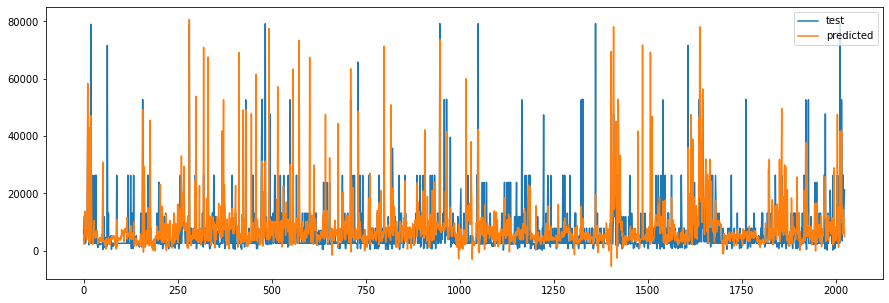

In [59]:
plt.plot(Final_Result_No_Out.GrossValue)
plt.plot(Final_Result_No_Out.GrossValuePrd)
plt.legend(['test', 'predicted'])

In [60]:
# GrossValue and GrossValuePrd less than 20,000
Final_Result_No_Out = Final_Result.loc[(Final_Result['GrossValue'] < 20000) & (Final_Result['GrossValuePrd']  < 20000)]

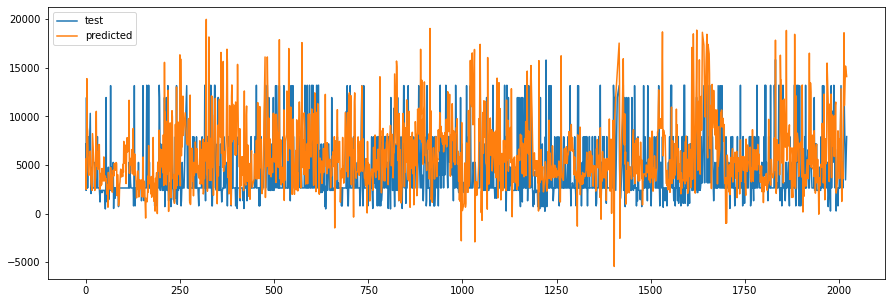

In [61]:
plt.plot(Final_Result_No_Out.GrossValue)
plt.plot(Final_Result_No_Out.GrossValuePrd)
plt.legend(['test', 'predicted'])

Conclusion: 

    1. 50% of test data is predicted correctly by the model